<a href="https://colab.research.google.com/github/Kim-JH-01/AI_lab_Juhun/blob/main/week12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
import io

# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [57]:
# 파일 업로드
print("Upload insurance.csv file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 데이터 읽기
data = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"Data shape: {data.shape}")

Upload insurance.csv file:


Saving insurance.csv to insurance.csv
Data shape: (1338, 7)


In [58]:
# 범주형 데이터 수치화
if data['sex'].dtype == 'object':
    data['sex'] = data['sex'].map({'female': 0, 'male': 1})

if data['smoker'].dtype == 'object':
    data['smoker'] = data['smoker'].map({'no': 0, 'yes': 1})

# 파생 변수 생성 (BMI와 흡연의 상호작용)
data['bmi_smoker'] = data['bmi'] * data['smoker']

# One-hot encoding
data = pd.get_dummies(data, columns=['region'], drop_first=True)

# 입력 변수와 타겟 변수 분리
X = data.drop('charges', axis=1).values.astype(np.float32)
y = data['charges'].values.astype(np.float32).reshape(-1, 1)

# 학습용, 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 데이터 정규화
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("Preprocessing complete.")

Preprocessing complete.


In [59]:
# 텐서 변환
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# 데이터셋 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 데이터 로더 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [60]:
class InsurancePredictor(nn.Module):
    def __init__(self, input_dim):
        super(InsurancePredictor, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

# 모델 초기화
input_dim = X_train.shape[1]
model = InsurancePredictor(input_dim).to(device)
print(model)

InsurancePredictor(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [61]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습률 스케줄러 설정
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=10
)

In [62]:
num_epochs = 300
train_losses = []
test_losses = []
best_test_loss = float('inf')

print("Start training...")

for epoch in range(num_epochs):
    # 학습 모드
    model.train()
    batch_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()

    avg_train_loss = batch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 평가 모드
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    avg_test_loss = val_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # 스케줄러 업데이트
    scheduler.step(avg_test_loss)

    # 최고 성능 모델 저장
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), 'best_model.pth')

    if (epoch + 1) % 50 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train: {avg_train_loss:.4f} | Test: {avg_test_loss:.4f} | LR: {current_lr:.6f}")

print(f"Training finished. Best Test Loss: {best_test_loss:.4f}")

# 최고 성능 모델 로드
model.load_state_dict(torch.load('best_model.pth'))

Start training...
Epoch [50/300] | Train: 0.1554 | Test: 0.1429 | LR: 0.000010
Epoch [100/300] | Train: 0.1569 | Test: 0.1430 | LR: 0.000000
Epoch [150/300] | Train: 0.1550 | Test: 0.1430 | LR: 0.000000
Epoch [200/300] | Train: 0.1553 | Test: 0.1430 | LR: 0.000000
Epoch [250/300] | Train: 0.1474 | Test: 0.1430 | LR: 0.000000
Epoch [300/300] | Train: 0.1416 | Test: 0.1430 | LR: 0.000000
Training finished. Best Test Loss: 0.1332


<All keys matched successfully>

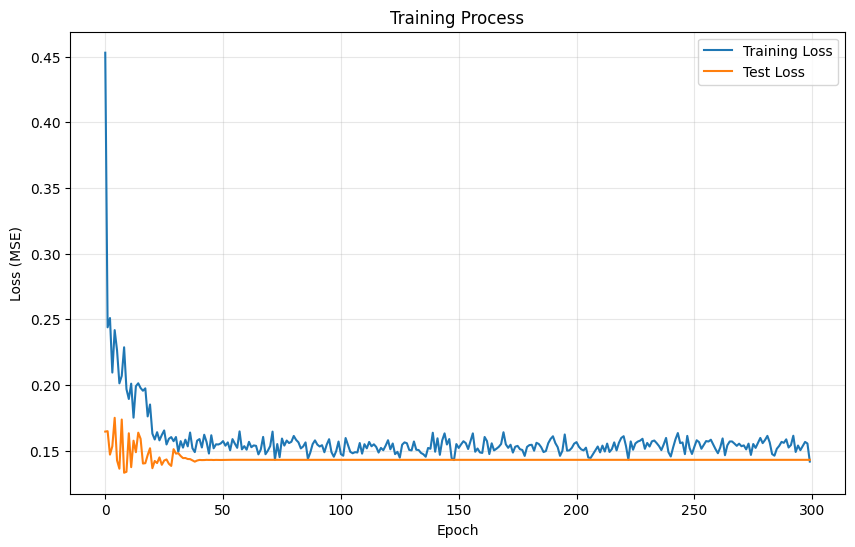

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Process')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [64]:
model.eval()
with torch.no_grad():
    pred_scaled = model(X_test_tensor.to(device)).cpu().numpy()

    # 역변환 (StandardScaler)
    y_pred = scaler_y.inverse_transform(pred_scaled)
    y_true = scaler_y.inverse_transform(y_test_tensor.numpy())

from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("-" * 30)
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print("-" * 30)

------------------------------
R2 Score: 0.8750
MAE: 2532.77
------------------------------


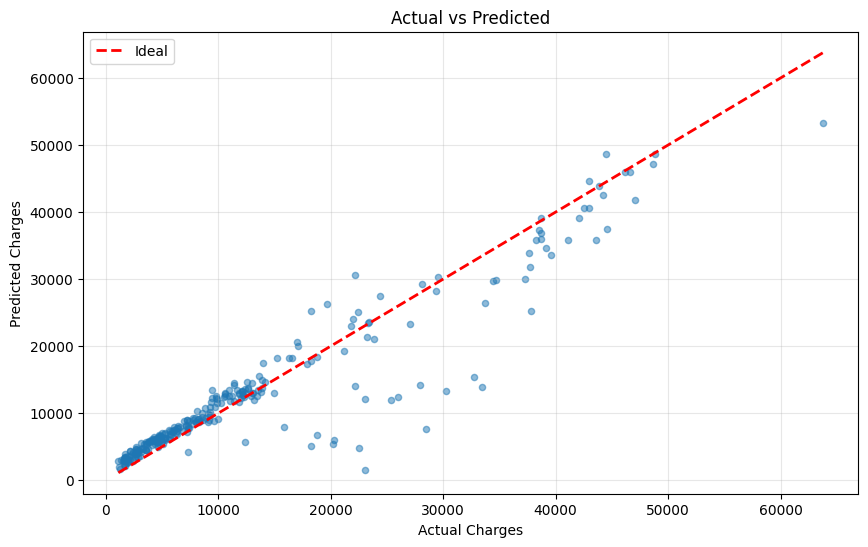

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 모델 파일 다운로드
#files.download('best_model.pth')